<a href="https://colab.research.google.com/github/palabebek/Machine-Learning/blob/main/UAS%20ML%20/%20UAS_2_Classification_Models_MLP_%E2%80%93_predict_discrete_categories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Install jika belum tersedia (hanya di Colab)
# !pip install tensorflow scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks


In [5]:
# Load dataset (sesuaikan path jika lokal)
df = pd.read_csv("KlasifikasiUTS.csv")

# Target = kolom int: 'Class'
X = df.drop("Class", axis=1)
y = df["Class"]

# Undersample data imbalance (rasio 1:4)
df_majority = df[df.Class == 0]
df_minority = df[df.Class == 1]
df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=len(df_minority) * 4,
                                   random_state=42)

df_balanced = pd.concat([df_majority_downsampled, df_minority])
X_bal = df_balanced.drop("Class", axis=1)
y_bal = df_balanced["Class"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [6]:
def create_mlp_model(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

model = create_mlp_model(X_train_scaled.shape[1])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_schedule = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

history = model.fit(X_train_scaled, y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stop, lr_schedule],
                    verbose=1)


Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7134 - loss: 0.5876 - val_accuracy: 0.9391 - val_loss: 0.3428 - learning_rate: 0.0010
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9267 - loss: 0.2723 - val_accuracy: 0.9543 - val_loss: 0.2215 - learning_rate: 0.0010
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9376 - loss: 0.2167 - val_accuracy: 0.9569 - val_loss: 0.1737 - learning_rate: 0.0010
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9549 - loss: 0.1773 - val_accuracy: 0.9594 - val_loss: 0.1521 - learning_rate: 0.0010
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9516 - loss: 0.1784 - val_accuracy: 0.9569 - val_loss: 0.1448 - learning_rate: 0.0010
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9510 - loss: 0.1767 - val_accuracy: 0.9569 - val_loss: 0.1383 - learning_rate: 0.0010
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9568 - loss: 0.1436 - val_ac

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       394
           1       0.99      0.83      0.90        98

    accuracy                           0.96       492
   macro avg       0.97      0.91      0.94       492
weighted avg       0.96      0.96      0.96       492

ROC AUC Score: 0.9801616077903242


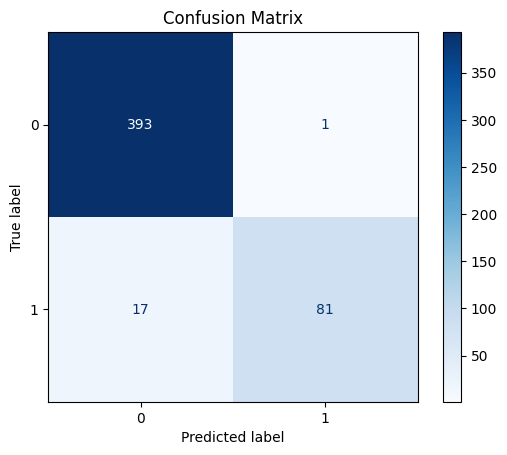

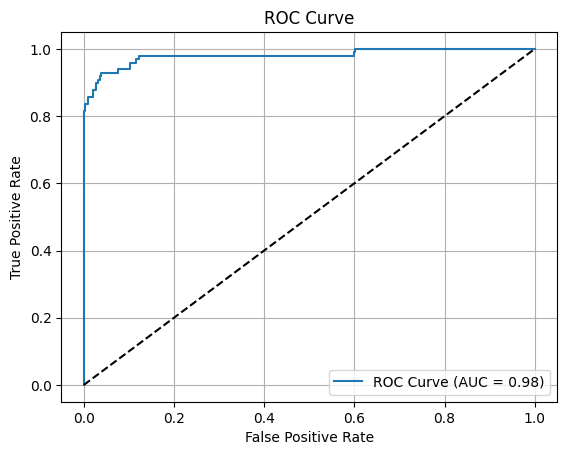

In [7]:
# Prediksi
y_pred_prob = model.predict(X_test_scaled).flatten()
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Evaluasi
print("Classification Report:\n", classification_report(y_test, y_pred_class))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_class, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_pred_prob):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [9]:
# Konversi ke tensor
X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_torch = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_torch = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# DataLoader
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


In [10]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.3)

        self.out = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = torch.sigmoid(self.out(x))
        return x


In [11]:
model = MLPClassifier(X_train_scaled.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
criterion = nn.BCELoss()

best_loss = np.inf
patience, trigger = 7, 0

for epoch in range(50):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_test_torch)
        val_loss = criterion(val_pred, y_test_torch).item()

    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

    scheduler.step(val_loss)
    if val_loss < best_loss:
        best_loss = val_loss
        trigger = 0
        best_model = model.state_dict()
    else:
        trigger += 1
        if trigger >= patience:
            print("Early stopping triggered.")
            break


Epoch 1, Train Loss: 26.4030, Val Loss: 0.3033
Epoch 2, Train Loss: 15.9058, Val Loss: 0.2034
Epoch 3, Train Loss: 12.2409, Val Loss: 0.1433
Epoch 4, Train Loss: 9.6665, Val Loss: 0.1296
Epoch 5, Train Loss: 8.9333, Val Loss: 0.1144
Epoch 6, Train Loss: 7.7155, Val Loss: 0.1057
Epoch 7, Train Loss: 7.8818, Val Loss: 0.1050
Epoch 8, Train Loss: 7.9068, Val Loss: 0.1024
Epoch 9, Train Loss: 7.2434, Val Loss: 0.0975
Epoch 10, Train Loss: 7.5267, Val Loss: 0.0967
Epoch 11, Train Loss: 6.8943, Val Loss: 0.0960
Epoch 12, Train Loss: 6.8072, Val Loss: 0.0948
Epoch 13, Train Loss: 6.8630, Val Loss: 0.0932
Epoch 14, Train Loss: 6.3472, Val Loss: 0.0875
Epoch 15, Train Loss: 6.2641, Val Loss: 0.0924
Epoch 16, Train Loss: 6.4252, Val Loss: 0.0876
Epoch 17, Train Loss: 5.7267, Val Loss: 0.0906
Epoch 18, Train Loss: 6.5886, Val Loss: 0.0915
Epoch 19, Train Loss: 5.6579, Val Loss: 0.0896
Epoch 20, Train Loss: 6.2439, Val Loss: 0.0874
Epoch 21, Train Loss: 6.2210, Val Loss: 0.0878
Epoch 22, Train Los

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       394
           1       1.00      0.87      0.93        98

    accuracy                           0.97       492
   macro avg       0.98      0.93      0.96       492
weighted avg       0.97      0.97      0.97       492

ROC AUC Score: 0.9870247591422356


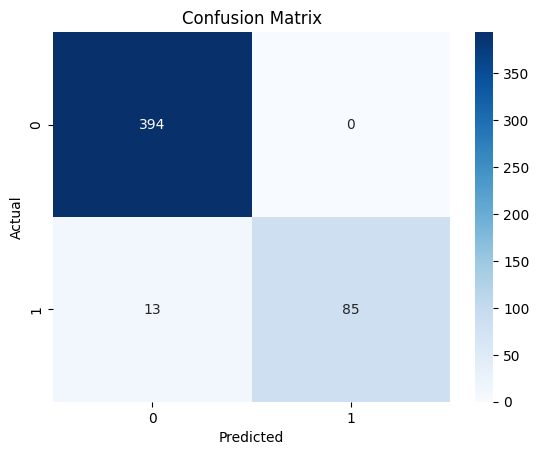

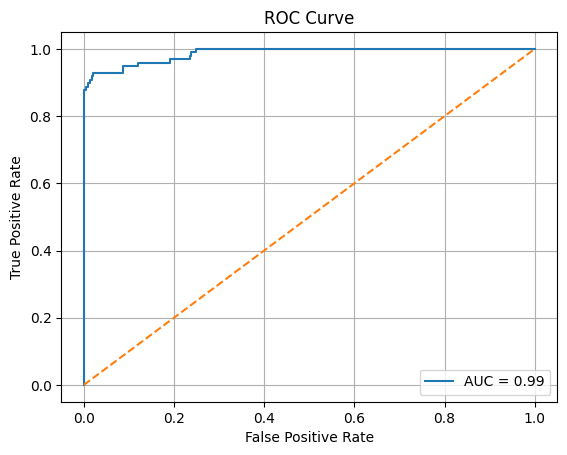

In [12]:
# Load best model
model.load_state_dict(best_model)
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_torch).squeeze().numpy()
    y_pred_class = (y_pred_prob > 0.5).astype(int)

# Metrics
print("Classification Report:\n", classification_report(y_test, y_pred_class))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_prob):.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


# Penjelasan Metrik & Analisa
* Accuracy: Baik jika data seimbang. Dalam kasus fraud (tidak seimbang), kurang optimal.

* Precision: Fokus pada mengurangi false positives. Penting saat ingin menghindari false alarm.

* Recall: Fokus pada mendeteksi sebanyak mungkin fraud. Lebih penting saat kesalahan lolos berisiko.

* F1-Score: Rata-rata harmonis Precision & Recall. Metrik terbaik saat data tidak seimbang.

* ROC-AUC: Mengukur kemampuan model membedakan kelas, semakin dekat ke 1 semakin bagus.

# Gunakan F1-Score dan ROC-AUC untuk membandingkan performa terbaik.